<a href="https://colab.research.google.com/github/jjschueder/7331DataMiningNotebooks/blob/master/lab3/RF_with_cluster_check_knnbestmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import warnings
warnings.filterwarnings('ignore')

#Lab 3 - Clustering, Association Rules, or Recommenders - Classification Evaluation after adding Clustering Feature
Daniel Clark, Joe Schueder, Jeff Washburn, Armando Vela

Import CSV file that was exported from the lab3 clustering notebook.
https://github.com/jjschueder/7331DataMiningNotebooks/blob/master/lab3/Lab3_Daniel_Jeff_Armando_Joe_final_v7.ipynb

In [38]:

import pandas as pd
from google.colab import drive
drive.mount('/content/drive/')
data = pd.read_csv("/content/drive/My Drive/ColabNotebooks/knnmergedf.csv")


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Load in model parameters for a Random Forest moedel that was previously determined to be the best classification of the alcohol data in lab2.

https://github.com/jjschueder/7331DataMiningNotebooks/blob/master/lab2/Lab2_Daniel_Jeff_Armando_Joe(Final).ipynb

The model has these parameters which was optimized through a grid search.  

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,  
                       criterion='gini', max_depth=20, max_features='auto',  
                       max_leaf_nodes=None, max_samples=None,  
                       min_impurity_decrease=0.0, min_impurity_split=None,  
                       min_samples_leaf=1, min_samples_split=2,  
                       min_weight_fraction_leaf=0.0, n_estimators=500,  
                       n_jobs=None, oob_score=False, random_state=101,  
                       verbose=0, warm_start=False)  

In [0]:
url_rfmodel = '/content/drive/My Drive/ColabNotebooks/rfmodelbasecluster.joblib'
#exporting model to drive
from joblib import dump, load
#dump(clf, url_rfmodel)

#importing model to new model name
clf = load(url_rfmodel)

In [40]:
data

,Unnamed: 0,sale_dollars_trans,cost_per_liter_trans,state_bottle_cost_trans,bottles_sold_trans,volume_sold_liters_trans,pack_trans,bottle_volume_ml_trans,profit_trans,totalcost_trans,revenue_trans,id_label,Cluster_Label
0,0,4.750136,2.735233,1.348073,2.995732,2.014903,2.995732,5.926926,3.653252,4.343805,4.750136,1,6
1,1,2.574900,5.570632,2.169054,0.000000,-2.995732,2.079442,3.912023,1.477049,2.169054,2.574900,1,6
2,2,5.000585,3.208825,2.803360,1.791759,1.791759,2.484907,6.907755,3.901973,4.595120,5.000585,2,5
3,3,6.636261,3.745890,3.052585,3.178054,2.890372,1.791759,6.620073,5.537964,6.230639,6.636261,3,6
4,4,5.121819,2.077296,2.231089,2.484907,3.044522,1.791759,7.467371,4.023922,4.715996,5.121819,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39978,39995,3.661508,2.968361,2.562639,0.693147,0.693147,2.484907,6.907755,2.563410,3.255786,3.661508,5,1
39979,39996,5.247445,2.985682,0.970779,3.871201,2.261763,3.871201,5.298317,4.148833,4.841980,5.247445,5,3
39980,39997,2.951780,4.848900,1.446919,1.098612,-1.897120,2.484907,3.912023,1.854734,2.545531,2.951780,5,3
39981,39998,4.787492,2.931194,0.916291,3.465736,1.856298,3.871201,5.298317,3.688879,4.382027,4.787492,5,3


Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis.

We obtained a dataset on Iowa Liquor Sales from Google Bigquery. The aim of recording the data set is for the state to track alcohol and liquor sales from wholesalers and retailers from the year 2012 through 2019. You can see some Exploratory Data Analysis of this dataset below:

Feature have previously been chosen in lab1, the purpose here to use those variables with the addtion of the cluster label to improve classification.   
https://github.com/jjschueder/7331DataMiningNotebooks/blob/master/lab1/msds7331_clark_schueder_vela_washburn.ipynb

In [41]:

%%time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn import metrics as mt

cv = StratifiedKFold(n_splits=10)

features = ['sale_dollars_trans', 'cost_per_liter_trans', 
       'state_bottle_cost_trans', 'bottles_sold_trans',
       'volume_sold_liters_trans', 'pack_trans', 'bottle_volume_ml_trans',
       'profit_trans', 'totalcost_trans', 'revenue_trans', 'Cluster_Label']

X2 = data[features].copy()

scaler = StandardScaler()
scaler.fit(X2)

#This makes our model's coefficients take on the same scale for accurate feature importance analysis
#Notice we scaled the data before the cross validation
X = scaler.transform(X2)

Y= data[['id_label']].copy()
Y2 = Y.values

#Divide data into test and training splits
from sklearn.model_selection import ShuffleSplit
#cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=0)

CPU times: user 17.4 ms, sys: 0 ns, total: 17.4 ms
Wall time: 17.5 ms


Now that we built our cross validation and assigned Xs and Ys, we will now work to create our training set and test set using SMOTE to balance our classifiers. Training size was 80% of our data and the test size was 20%.

In [0]:
from sklearn import metrics as mt
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, TimeSeriesSplit, StratifiedShuffleSplit
# train and test split before resampling
X1_train, X1_test, y1_train, y1_test = train_test_split(X, Y, test_size = 0.2, random_state = 101)

In [43]:
clf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=101,
                       verbose=0, warm_start=False)

Running through each iteration of our kfold, we can see that our accuracy score ranges from 0.43 to 0.83.

In [44]:
from sklearn.model_selection import cross_val_score

RF_accuracy = cross_val_score(clf, X, y=Y2, cv=cv)
RF_acc=RF_accuracy.mean()
print('Average RF accuracy score is : {}' .format(RF_acc))

Average RF accuracy score is : 0.6524698708443994


In [45]:
RF_accuracy

array([0.66541635, 0.82370593, 0.76544136, 0.45947974, 0.73261631,
       0.6935968 , 0.63031516, 0.73286643, 0.57628814, 0.44497249])

Accuracy and confusion matrix scores match pretty closely with prior model without cluster feature. 

In [46]:
 for fold, (train_index, test_index) in enumerate(cv.split(X,Y2)):
     X_train = X[train_index]    
     y_train = Y2[train_index]  # Based on your code, you might need a ravel call here, but I would look into how you're generating your y
     X_test = X[test_index]
     y_test = Y2[test_index]  # See comment on ravel and  y_train
     clf.fit(X_train, y_train)
     y_pred = clf.predict(X_test)
     acc = mt.accuracy_score(y_test,y_pred)
     conf = mt.confusion_matrix(y_test,y_pred)
     print("====Iteration",fold," ====")
     print("accuracy", acc )
     print("confusion matrix\n",conf)

====Iteration 0  ====
accuracy 0.6654163540885222
confusion matrix
 [[ 138    2   16    3   27   34   19]
 [   0  142    2    0    4   24    0]
 [  40   56  682    1   14  108    3]
 [  24    1   71   87   34    9   59]
 [  56   42   26    0  225  159   28]
 [  36    3   11    6    9 1225   21]
 [  47   27  185   12   63   56  162]]
====Iteration 1  ====
accuracy 0.8237059264816204
confusion matrix
 [[ 116    5   72    1   13   24    8]
 [   3  134   14    1    6   14    0]
 [  12   22  842    6    5    5   12]
 [   0    0    1  273    2    7    2]
 [   0    0    2   11  382   90   51]
 [   3    0    3    0   18 1277   10]
 [  41    4   40   24  135   38  270]]
====Iteration 2  ====
accuracy 0.765441360340085
confusion matrix
 [[ 128    1   57   14   12   20    7]
 [   2   99   24    0   37    8    1]
 [  40   21  813    1    1    1   28]
 [   0    0    0  282    0    3    0]
 [  32   33    6    1  256  196   12]
 [  24    2    7    1   50 1214   13]
 [  76    0    9   97   16   85  26

Our precision, recall and F1 scores are very high, which suggest we have a strong model, but not stronger than previously.

In [0]:
clf.fit(X1_train, y1_train)
y_pred = clf.predict(X1_test)
conf = mt.confusion_matrix(y1_test,y_pred)

In [48]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
print("Precision Score is: {}" .format(precision_score(y1_test,y_pred, average='weighted')))
print("Recall Score is: {}" .format(recall_score(y1_test,y_pred, average='weighted')))
print("F1 Score is: {}" .format(f1_score(y1_test,y_pred, average='weighted')))

Precision Score is: 0.9286648015323086
Recall Score is: 0.9293485056896336
F1 Score is: 0.9287287536418436


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
# source of code: https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)


Accuracy: 0.9293485056896336


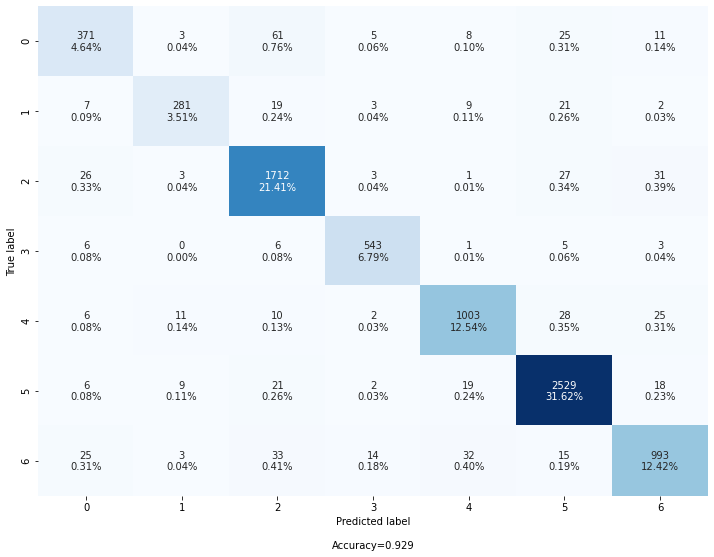

In [50]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y1_test,y_pred))
matrix = confusion_matrix(y1_test,y_pred)
make_confusion_matrix(matrix, figsize=(12,9), cbar=False)

In [0]:
def per_class_accuracy(ytrue,yhat):
    conf = mt.confusion_matrix(ytrue,yhat)
    norm_conf = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]
    return np.diag(norm_conf)

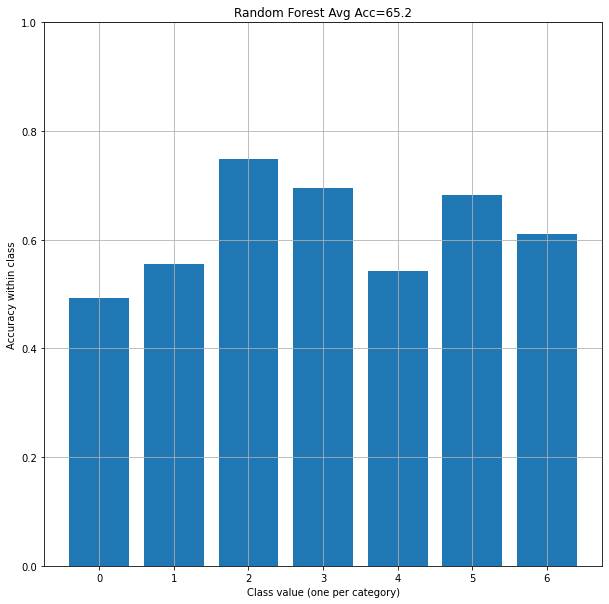

In [52]:
totalacc = 0
totalprec = 0
totalrec= 0
totalf1  = 0
listx = []
perclasslist = []
for fold, (train_index, test_index) in enumerate(cv.split(X,Y2)):
     X_train = X[train_index]    
     y_train = Y2[train_index]  # Based on your code, you might need a ravel call here, but I would look into how you're generating your y
     X_test = X[test_index]
     y_test = Y2[test_index]  # See comment on ravel and  y_train
#     sm = SMOTE(random_state=101)
#     X_train_oversampled, y_train_oversampled = sm.fit_sample(X_train, y_train)
     clf.fit(X_train, y_train) 
     y_pred = clf.predict(X_test)
     acc = mt.accuracy_score(y_test,y_pred)
     prec = precision_score(y_test, y_pred, average='weighted')
     rec = recall_score(y_test, y_pred, average='weighted')
     f1 = f1_score(y_test, y_pred, average='weighted')
     perclassaccuracy = per_class_accuracy(y_test,y_pred)
     perclasslist.append(perclassaccuracy.tolist())
     totalacc += acc
     totalprec += prec
     totalrec += rec
     totalf1 += f1
     conf = mt.confusion_matrix(y_test,y_pred)
#     print("Sum: ", totalacc, "Current: ", acc,"Per Class",perclassaccuracy,"\n")


avgaccuracy = 100*totalacc / cv.n_splits
avgprec = 100*totalprec / cv.n_splits
avgrec = 100*totalrec / cv.n_splits
avgf1 = 100*totalf1 / cv.n_splits
 

listx.append(("Model 2", "Random Forest", avgaccuracy, avgprec, avgrec, avgf1))

perclassdf = []
perclassdf = pd.DataFrame(perclasslist)
#perclassdf = perclassdf.transpose()
#perclassdf

perclassavg = perclassdf.mean(axis = 0) 
#perclassavg

plt.bar(range(len(perclassavg)), perclassavg)
plt.xlabel('Class value (one per category)')
plt.ylabel('Accuracy within class')
#plt.title(title+", Total Acc=%.1f"%(totalaccuracy))
plt.title("Random Forest Avg Acc=%.1f"%(avgaccuracy))
plt.grid()
plt.ylim([0,1])
plt.show()

We cand see that accuracy by liquor class is similiar to prior predicitons.

In [53]:
listx

[('Model 2',
  'Random Forest',
  65.24698708443995,
  66.52122593943555,
  65.24698708443995,
  63.9843127529805)]

In [54]:
dfobj = pd.DataFrame(listx, columns = ['Model Number', 'Model','Accuracy' , 'Precision', 'Recall', 'F1'], index=['0', '1', '2'])
dfobj.head(1)

,Model Number,Model,Accuracy,Precision,Recall,F1
0,Model 2,Random Forest,65.246987,66.521226,65.246987,63.984313


In [55]:
ylist = Y['id_label'].values.astype('int64')
ylist
ylist.shape

(39983,)

In [0]:
from sklearn.preprocessing import label_binarize
ybinary = label_binarize(ylist, classes=[1, 2, 3, 4, 5, 6, 7])
n_classes = ybinary.shape[1]
X_train4, X_test4, y_train4, y_test4 = train_test_split(X,ybinary, test_size=0.2) # 70% training and 30% test

In [0]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, auc, roc_curve

In [0]:
from sklearn.ensemble import GradientBoostingClassifier,GradientBoostingRegressor,AdaBoostClassifier,RandomForestClassifier, BaggingClassifier

In [59]:
%%time
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_val_predict
# Learn to predict each class against the other
rfclassifiercv = OneVsRestClassifier(RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=101,
                       verbose=0, warm_start=False))
rfbinarymodel = rfclassifiercv.fit(X_train4, y_train4)
rfbinaryscore = rfclassifiercv.predict(X_test4)
y_score = cross_val_predict(rfclassifiercv, X, ybinary, cv=10 ,method='predict_proba')

CPU times: user 21min 33s, sys: 5.54 s, total: 21min 39s
Wall time: 21min 41s


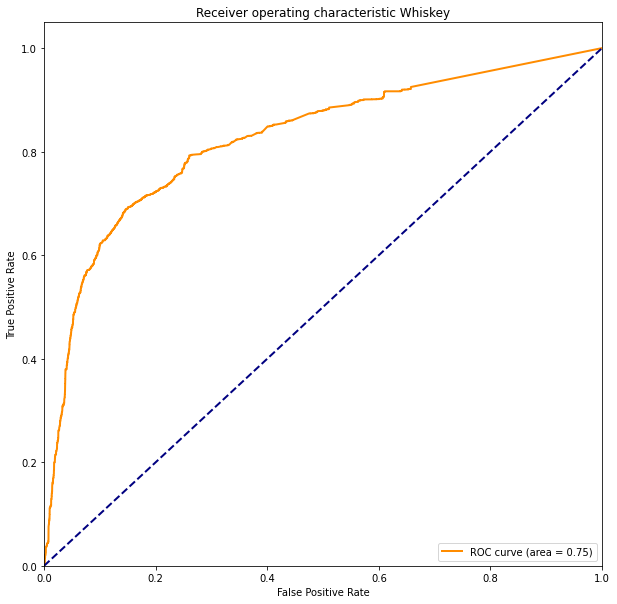

In [60]:
#X1_train, X1_test, y1_train, y1_test
#y_score = classifier.fit(X_train3, y_train3).decision_function(X_test3)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(ybinary[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(ybinary.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
#Plot of a ROC curve for a specific class

plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[3])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic Whiskey')
plt.legend(loc="lower right")
plt.show()

Looking at the average value ROC curve, we can see this model has the same  area under the curve.

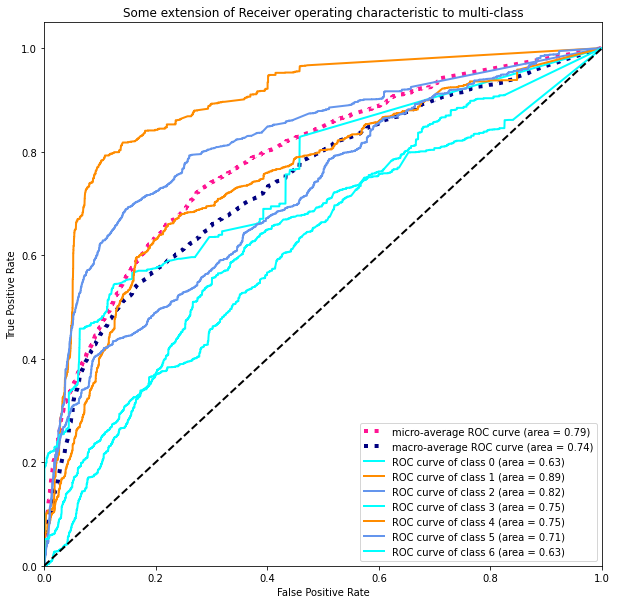

In [61]:
roc_list =[]
from scipy import interp
from itertools import cycle
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
roc_list.append(("Model 2", "RF", roc_auc["macro"],fpr["macro"],tpr["macro"]))
# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.rcParams["figure.figsize"] = (10,10)
plt.show()

With an ROC curve of the classes, we can see the random forest was pretty accurate in predicting each of the classes, with a positive outcome on each curve.

All the meausres together is much the same as from lab2.

In [62]:
dfroc = pd.DataFrame(roc_list, columns = ['Model Number', 'Model', 'ROC', "fpr", "tpr"], index=['0', '1', '2'])
dfroc.head(1)

,Model Number,Model,ROC,fpr,tpr
0,Model 2,RF,0.741722,"[0.0, 2.6932399676811204e-05, 0.00018852679773...","[5.987306909352174e-05, 0.014735843530348075, ..."
